## Mutants:
#### since the discovery of their existence they have been regarded with fear, suspicious, often hatred
Implement a rMPIPD where strategies are allowed to mutate. The goal is to simulate the effect of genetic mutations and the effect of natural selection. A parameter (gene) should encode the attidue of an individual to cooperate, such gene can mutate randomly and the corresponding phenotype should compete in the MPIPD such that the best-fitted is determined.  


## Solution
The most compact way to implement this using the previous results and defined elements is to implement a more complex structure which can behave differently according to a memory element. This can be done using a class to manage Mutants: a mutant should have a genome which contains the gene that allows him to mutate and determine the nature of the mutation. To simulate this, the Mutant is a guy that is allowed to use some of the previous defined strategies, each one with a defined probability that changes during the match or tournament; to do so it is always allowed to have access to nice_guy and bad_guy, and from those can create mainly_nice, mainly_bad and random. At every moment the class can be called to get a move and the mutate function can be invoked to make it change.
Every mutant can encode its own information via genome, containing information about their genes and their probabilities.
For the evolutionary process no penalty will be provided for a mutant with higher number of genes, because more variety increases also the possibility of "bad" mutations in the future

In [85]:
class mutant :

    # CONSTRUCTOR
    # every mutant is created with a name and a list of tuples, containing accessible strategies and their initial weight
    def __init__( self, name, starting_strategy ) : 
        self.name = name
        # the series of trategies that can be chosen, starting from a list of strategies and their probabilities
        self.strategy_dic = { i[0] : strategies[i[0]] for i in starting_strategy } 
        # NiceGuy and BadGuy incarnate the basic behaviour, thus are always included as last elements, if not already present
        self.strategy_dic[ 'NiceGuy' ] = nice_guy
        self.strategy_dic[ 'BadGuy' ] = bad_guy
        # this process creates an internal dictionary similar to strategies but with limited entries, useful for later cycles
        # the gene in rapresented by the strategy list, a list of values that determine which strategy use to create the next move
        # this is rapresented by a normalized range of values chosen by a uniform distribution
        starting_weight = [ i[1] for i in starting_strategy ]
        self.strategy = np.array( starting_weight/np.sum(starting_weight) )
        # reshaping the weight array to consider added elements
        self.strategy.resize( len( self.strategy_dic ) )
        self.dic_keys = list( self.strategy_dic.keys() )

    # alternative constructor: it takes genome, a string of gene letters, the ripetition of each means a different probability
    @classmethod
    def from_genome( cls, genome ) :
        g_list = [ ( g, genome.count( g ) ) for g in list( cls.genes.keys() ) if ( genome.count( g ) ) ]
        total_g = sum( [ i[1] for i in g_list ] )
        strategy = [ ( cls.genes[ g[0] ] , float( g[1] ) / float( total_g )  ) for g in g_list ]
        return cls( genome, strategy )
    
    # REPR OUTPUT
    def __repr__( self ) :
        return f"<Mutant name:{self.name} strategy_dic:{self.strategy_dic} strategy:{self.strategy}>"

    # PRINTING OUTPUT
    def __str__( self ) :
        return f"Mutant class:\n   Name: {self.name}\n   Strategies in the genome: {[ i for i in self.strategy_dic]}\n   Gene values: {self.strategy}\n"

    # DEFINING HOW COPY BEHAVE, PREVENTING A SHALLOW COPY
    def __copy__( self ) :
        # returning a new object made from the same basic informations, name and list of couples of name of strategy used and its weight 
        return mutant( self.name, zip( self.dic_keys, self.strategy ) )

    # return the weigth of a specific strategy name as in the original dictionary
    def get_weigth( self, name ) :
        for i in range( len( self.dic_keys ) ) :
            if ( self.dic_keys[ i ] ==  name ) :
                return self.strategy[ i ]
        return 0.0
    
    # defining the generic function that returns a move for a mutant
    def move( self, round_number = 0, match_history = [[]], player_index = 0 ) :
        # generating a random value to chose the strategy
        u = npr.random( )
        # cumulative sum of weights
        cumulative = [ np.sum( self.strategy[ 0 : i + 1 ] ) for i in range( self.strategy.shape[ 0 ] ) ]
        # cycling over strategies weights
        for i in range( len( cumulative ) ) :
            if ( u < cumulative[ i ] ) : 
                return self.strategy_dic[ self.dic_keys[ i ] ]( round_number, match_history, player_index )    

    # function to convert genes and strategy into the genome, a string of encoded letters that rapresent most of the information
    # N rapresents the number of total genes in the genome, and in a way the precision of this conversion
    def genome( self, N=100 ) :
        # starting with a void string
        genome = ''
        # cycling over all possible genes
        for g in self.genes :
            # checking if the gene is present in the genome
            if ( self.genes[g] in self.dic_keys ) :
                # appending element using python string operations
                genome += ( g * int( np.round( self.strategy[ self.dic_keys.index( self.genes[g] ) ] * N ) ) )
        return genome
    
    # function to change genome (strategy) corresponding to previous round results
    def mutate( self ) :
        # recovering existing strategy
        strat = self.strategy 
        
        # updating strategy: for each weight a new one is produced based on a gaussian
        # this makes small differences more likely; the gaussian is centered on the previous value and has little std
        # considering these are normalized probability their value is always less than 1
        std = 0.096
        # creating an array of normal distributed value centered in the previous values, given std and same shape as strategy 
        p = npr.normal( loc = strat, scale = std, size = strat.shape )
        # updating strategy only for those distributions that has positive outcome
        # this way genes that previously where 0. are less likely to sudden emerge
        strat[ p > 0. ] = p[ p > 0. ]
        # renormalize strategy so that move can be used with a uniform distribution
        self.strategy = strat / np.sum( strat )

    genes = {
            'N' : 'NiceGuy',       # N for Nice Guy
            'B' : 'BadGuy',        # B for Bad Guy
            'U' : 'TitForTat',     # U for as you did
            'R' : 'ResentfulGuy',  # R for Resentful Guy
            'T' : 'Thanos',        # T for Thanos, the most Balancing Guy
            'F' : 'TrustingGuy',   # F for Fides,Fidei the Classical Trust
            'M' : 'MidResentful',  # M for Mid-Resentful Guy
            'S' : 'ScammingGuy',   # S for Scamming Guy
            'I' : 'ReverseTft',    # I as opposite of you, opposite to the Tit for Tat definition
            }
# the mutation can be encoded in a second moment by the usage of 
# @classmethod
# def mutate( cls, * x ) :
#     cls.strategy = x

In [28]:
# a function to faster get mutant list for tourney
# mode in the list identify the model used
def get_m_list( mode, par_list=[], N_mut = 1000, N_gen = 100 ) : 
    # some fancy default values to initialize mutant from a genome
    default_dic = {
        "gods" : ['ALATHANDER', 'BACCOB', 'BEORY', 'CELESTIAN', 'CORELLON_LARETHIAN', 'EHLONNA', 'ERYTHNUL', 'FHARLANGHN', 'HEIRONEOUS', 'HEXTOR', 'ISTUS', 'IUZ', 'JORAMY', 'KURELL', 'LENDOR', 'NERULL', 'OBAD-HAI', 'OLIDAMMARA', 'PELOR', 'PROCAN', 'RALISHAZ', 'RUDD', 'ST._CUTHBERT', 'TRITHEREON', 'VECNA', 'WAUKEEN',
                'AURIL', 'AZUTH', 'BANE', 'BHAAL', 'CHAUNTEA', 'CYRIC', 'DENEIR', 'ELDATH', 'GOND', 'HELM', 'ILMATER', 'KELEMVOR', 'LATHANDER', 'LEIRA', 'LLIIRA', 'LOVIATAR', 'MALAR', 'MASK', 'MIELIKKI', 'MILIL', 'MORADIN', 'MYRKUL', 'MYSTRA', 'OGHMA', 'SELUNE', 'SHAR', 'SHARESS', 'SHAUNDAKUL', 'SILVANUS', 'SUNE', 'TALONA', 'TALOS', 'TEMPUS', 'TORM', 'TYMORA', 'TYR', 'UMBERLEE', 'WAUKEEN',
                'CHEMOSH', 'GILEAN', 'HIDDUKEL', 'KIRI-JOLITH', 'MAJERE', 'MISHAKAL', 'MORGION', 'PALADINE', 'SARGONNAS', 'TAKHISIS', 'ZEBOIM',
                'AUREON', 'BALINOR', 'DOL_ARRAH', 'DOL_DORN', 'ARAWAI', 'BOLDREI', 'DEVICE', 'EBERRON', 'KORD', 'OLLADRA', 'ONATAR', 'THE_TRAVELER', 'THE_SHADOW',
                'ANUBIS', 'APOPHIS', 'BAST', 'HORUS', 'ISIS', 'RA', 'SET', 'SOBEK', 'THOTH',
                'APOLLO', 'ARES', 'ARTEMIS', 'ATHENA', 'DEMETER', 'DIONYSUS', 'HADES', 'HECATE', 'HELIOS', 'HERMES', 'POSEIDON', 'ZEUS',
                'AEGIR', 'BALDER', 'FORSETI', 'FREYA', 'FREY', 'HEIMDALL', 'HELA', 'LOKI', 'ODIN', 'THOR', 'TYR',
                'BLIBDOOLPOOLP', 'CORELLON_LARETHIAN', 'DEEP_SASHELAS', 'EADRO', 'GARL_GLITTERGOLD', 'GRUUMSH', 'HRUGGEK', 'KURTULMAK', 'LOLTH', 'MAGLUBIYET', 'MORADIN', 'RILLIFANE_RALLATHIL', 'SEHANINE_MOONBOW', 'SHEELA_PERYROYL', 'TIAMAT', 'YONDALLA'
                ],
        "disney" : ['SNOW_WHITE', 'CINDERELLA', 'AURORA', 'ARIEL', 'BELLE', 'JASMINE', 'POCAHONTAS', 'MULAN', 'TIANA', 'RAPUNZEL', 'MERIDA', 'MOANA',
                'PRINCE_CHARMING', 'PRINCE_PHILLIP', 'ERIC', 'BEAST', 'ALADDIN', 'JOHN_SMITH', 'LI_SHANG', 'NAVEEN', 'FLYNN_RIDER', 'KRISTOFF',
                'WOODY', 'BUZZ_LIGHTYEAR', 'MIKE_WAZOWSKI', 'SULLEY', 'MR._INCREDIBLE', 'ELASTIGIRL', 'DORY', 'MARLIN', 'LIGHTNING_MCQUEEN', 'MERIDA', 'JOY', 'SADNESS', 'SOUL',
                'MICKEY_MOUSE', 'MINNIE_MOUSE', 'DONALD_DUCK', 'GOOFY', 'PLUTO', 'DAISY_DUCK',
                'MALEFICENT', 'URSULA', 'CRUELLA_DE_VIL', 'SCAR', 'JAFAR', 'CAPTAIN_HOOK', 'QUEEN_OF_HEARTS', 'GASTON', 'HADES', 'QUEEN_GRIMHILDE',
                'SIMBA', 'MUFASA', 'NALA', 'TIMON', 'PUMBAA', 'BAMBI', 'DUMBO', 'STITCH', 'LADY', 'TRAMP',
                'MUSHU', 'GENIE', 'SEBASTIAN', 'FLOUNDER', 'OLAF', 'PASCAL', 'RAJAH', 'MEEKO', 'ABU', 'LUMIERE', 'COGSWORTH'
                ],
        "nobel" : ['MARTIN_LUTHER_KING_JR.', 'MOTHER_TERESA', 'NELSON_MANDELA', 'BARACK_OBAMA', 'DALAI_LAMA', 'MALALA_YOUSAFZAI', 'JIMMY_CARTER', 'DESMOND_TUTU', 'WANGARI_MAATHAI', 'HENRY_KISSINGER',
                'ALBERT_CAMUS', 'ERNEST_HEMINGWAY', 'GABRIEL_GARCÍA_MÁRQUEZ', 'TONI_MORRISON', 'PABLO_NERUDA', 'JEAN-PAUL_SARTRE', 'ALICE_MUNRO', 'BOB_DYLAN', 'KAZUO_ISHIGURO', 'MARIO_VARGAS_LLOSA',
                'ALBERT_EINSTEIN', 'MARIE_CURIE', 'RICHARD_FEYNMAN', 'STEPHEN_HAWKING', 'MAX_PLANCK', 'ENRICO_FERMI', 'WERNER_HEISENBERG', 'NIELS_BOHR', 'ERNEST_RUTHERFORD', 'PETER_HIGGS',
                'LINUS_PAULING', 'MARIE_CURIE', 'DMITRI_MENDELEEV', 'FRITZ_HABER', 'IRÈNE_JOLIOT-CURIE', 'ROSALIND_FRANKLIN', 'ADOLF_VON_BAEYER', 'HAROLD_UREY', 'AHMED_ZEWAIL', 'AARON_KLUG',
                'JONAS_SALK', 'ALEXANDER_FLEMING', 'WATSON_AND_CRICK', 'PAUL_EHRLICH', 'BARBARA_MCCLINTOCK', 'GERTRUDE_ELION', 'ELIZABETH_BLACKBURN', 'TU_YOUYOU', 'RALPH_STEINMAN', 'HERMANN_MULLER',
                'MILTON_FRIEDMAN', 'PAUL_KRUGMAN', 'JOSEPH_STIGLITZ', 'AMARTYA_SEN', 'GARY_BECKER', 'FREDERICK_HAYEK', 'DANIEL_KAHNEMAN', 'ROBERT_MERTON', 'VERNON_SMITH', 'OLIVER_WILLIAMSON'
                ],
        "physicist" : ['ISAAC_NEWTON', 'GALILEO_GALILEI', 'JAMES_CLERK_MAXWELL', 'MICHAEL_FARADAY', 'DANIEL_BERNOULLI', 'HENRY_CAVENDISH', 'JOSEPH_PRIESTLEY', 'ANTOINE_LAVOISIER', 'JOSEPH_FOURIER', 'JOHANN_CARL_FRIEDRICH_GAUSS',
                'MAX_PLANCK', 'ALBERT_EINSTEIN', 'NIELS_BOHR', 'WERNER_HEISENBERG', 'ERWIN_SCHROEDINGER', 'WOLFGANG_PAULI', 'PAUL_DIRAC', 'LOUIS_DE_BROGLIE', 'RICHARD_FEYNMAN', 'MURRAY_GELL-MANN',
                'STEPHEN_HAWKING', 'MICHIO_KAKU', 'BRIAN_GREENE', 'LEONARD_SUSSKIND', 'CARLO_ROVELLI', 'PETER_HIGGS', 'EDWARD_WITTEN', 'ROGER_PENROSE', 'CARLO_RUBBIA', 'SHELDON_GLASHOW',
                'ENRICO_FERMI', 'MARIE_CURIE', 'ERNEST_RUTHERFORD', 'LISE_MEITNER', 'ARTHUR_COMPTON', 'OTTO_HAHN', 'GLENN_SEABORG', 'GEORGE_ANTON_OLAH', 'CLINTON_DAVISSON', 'ARTHUR_SCHAWLOW',
                'CARL_SAGAN', 'NEIL_DEGRASSE_TYSON', 'SUBRAHMANYAN_CHANDRASEKHAR', 'VERA_RUBIN', 'JOCELYN_BELL_BURNELL', 'STEPHEN_HAWKING', 'MARTIN_REES', 'KATI_MÓRÓ', 'DAN_HOOPER', 'JANNA_LEVIN',
                'JENNIFER_DOUDNA', 'KIMBERLY_BRYANT', 'DONNA_STRICKLAND', 'ANDREA_GHEZ', 'FRANÇOISE_BARRÉ-SINOUSSI', 'EMMANUELLE_CHARPENTIER', 'MARGARET_MURNANE', 'DONNA_STRICKLAND', 'FABIOLA_GIANOTTI', 'SARA_SEAGER', 'MARCO_ZANETTI'
                ],
        "pod" : [ 'LENA_MARGHERITA', 'DI_LUCIA_SOFIA', 'CAVALLIN_JONATHAN', 'POCCIANI_GABRIELE', 'PONCHIO_MATTIA', 'CAFAGNO_SAMUELE',
                  'BROCCO_LUCA', 'PIRAZZO_TOMMASO', 'PIERIPOLLI_LEONARDO', 'SCHIAVINATO_ALBERTO', 'BELLI_LUIGI', 'TAMARIN_CHIARA', 'TUSCANO_ALESSIO',
                  'BORTOLATO_ANGELA', 'SECCO_BENEDETTO', 'NAPOLEONE_GIOVANNI', 'BEZZI_FILIPPO', 'CONTE_WILLIAM', 'FASIOLO_GIORGIA', 'GASPAROTTO_GIACOMO',
                  'EDOARDO_D_AMORE', 'ZARA_MIRIAM', 'CORTE_RICCARDO', 'JAMILOV_JAVLONBEK', 'BEATRICE_BERGAMIN',
                ],
        "test" : [ 'NNNB', 'BBBN', 'UUB', 'NNU', 'RNN', 'URR', 'BRU'],
    }
    genes = np.asarray([ 'N', 'B', 'U', 'R', 'T', 'F', 'M', 'S','I' ])
    # checking the type of input
    if isinstance( mode, str ):
        # if it mathces the name of some default list, a list of mutant with that genome is created
        if ( mode in list( default_dic.keys() ) ) :
            m_dic = { name : mutant.from_genome( name ) for name in default_dic[ mode ] }
        # the repeat mode allows to create a list of the same base strategy with a first mutation step
        elif ( mode == "repeat" ) : 
            par_list *= N_mut
            m_dic = {}
            for name in par_list :
                m = mutant.from_genome( name )
                m.mutate()
                m_dic[ m.genome( N_gen ) ] = copy.deepcopy( m )
        # the genome mode allows a direct list of genomes to be given as second parameter
        elif ( mode == "genome" ) : 
            m_dic = { name : mutant.from_genome( name ) for name in par_list }
        # the brute mode allows a direct list of standard constructor input to be given as second parameter
        elif ( mode == "brute" ) : 
            m_dic = { par[0] : mutant( par ) for par in par_list }
        # the shuffle mode allows to create a random selection of the elements of the list to create various genome from set genes
        elif ( mode == "shuffle" ) : 
            r_genomes = [ np.asarray(par_list)[ npr.randint( 0, len(par_list), size=N_gen ) ] for i in range(N_mut) ]
            genomes = [ (lambda x: ''.join( i for i in x ) )( g ) for g in r_genomes ]
            m_dic = {}
            for gene in genomes :
                m = mutant.from_genome( gene )
                m.mutate()
                m_dic[ m.genome( N_gen ) ] = copy.deepcopy( m )
        # if no specific mode is provided, a random selection will be produced
        else :
            r_genomes = [ genes[ npr.randint( 0, 9, size=N_gen ) ] for i in range(N_mut) ]
            genomes = [ (lambda x: ''.join( i for i in x ) )( g ) for g in r_genomes ]
            m_dic = {}
            for gene in genomes :
                m = mutant.from_genome( gene )
                m.mutate()
                m_dic[ m.genome( N_gen ) ] = copy.deepcopy( m )
    # if the first parameter is a number, a random selection of that lenght is produced
    else :
        N_mut = mode
        r_genomes = [ genes[ npr.randint( 0, 9, size=N_gen ) ] for i in range(N_mut) ]
        genomes = [ (lambda x: ''.join( i for i in x ) )( g ) for g in r_genomes ]
        m_dic = {}
        for gene in genomes :
            m = mutant.from_genome( gene )
            m.mutate()
            m_dic[ m.genome( N_gen ) ] = copy.deepcopy( m )
    m_keys = list( m_dic.keys() )
    return m_dic, m_keys

In [29]:
def m_tourney( player_list=[], N_rounds = 10, M = Payoff):
    # the player_list here is already made and given by input
    # Compute the combinations
    matchups = list(itertools.combinations(player_list, 2))
    # List which will be used to have the scores of each match by the side of the two opponents
    list_with_scores = []
    # Loop over the combinations one by one
    for comb in matchups:
        # Player1 and Player2 strategies
        player1 = comb[0]
        player2 = comb[1]
        # Initiliaze an empty list to store the results over the match
        AllRewards = []
        # Do the match between the two players and update the rewards; The ordered syntax for match is:
        AllRewards =  match(player1, player2, N_rounds, M)
        # Retrieve the final scores for Player1 and Player2 as the last element in the list
        R1, R2 = AllRewards[-1][0], AllRewards[-1][1]
        list_with_scores.append( comb + (R1,R2) )
        
    # Compute the score for each named player and add it to the list
    FinalScores = []
    for player in player_list :
        SumOver1 = np.sum([ match[2] for match in list_with_scores if (match[0] == player) ])
        SumOver2 = np.sum([ match[3] for match in list_with_scores if (match[1] == player) ])
        FinalScores.append(SumOver1 + SumOver2)
    Results = [ ( player_list[i], FinalScores[i] ) for i in range( len( player_list ) ) ]
    # return Results
    return ( sorted( Results, reverse=True, key=lambda x: x[1] ) )

In [86]:
# The iterated tournament function is slightly different; Here every strategy should appear only once,
# and the number of posible deleted and added subjects is not fixed

# Iterate the tournament process: new parameter "iter" to set the number of iterations of the tournament
# the parameter pressure rapresent a naive environmental pressure toward the natural selection process
def m_tournament( participants, part_names, N_rounds = 10, iter=50, pressure = 0,  M = Payoff):

    # number of participants, usefull later
    part_num = len( part_names )

    # dictionary to track usage of strategies
    strat_usage = { s : 0.0 for s in mutant.genes.values() }
    best_strat = { s : 0.0 for s in mutant.genes.values() }
    
    # if no pressure provided, an arbitrary hight pressure (square root of total individuals perish) is applied
    if ( pressure == 0 ) :
        pressure = int( np.round( np.sqrt( part_num ) ) )
    
    # adding to dictionary strategies the mutant moves as new strategies (this allows to use the existing framework)
    for name in part_names :
        strategies[ name ] = participants[ name ].move
        
    # set a counter for the while loop
    t_counter = 0
    
    # array to store all the results of each tournamen
    classification = []

    # computing the value of usage of each strategy
    for p in participants:
        for name in participants[p].strategy_dic :
            strat_usage[ name ] += participants[p].get_weigth( name ) / part_num
    
    # pandas dataframe to store the usage of native strategies
    frames = pd.DataFrame( list(strat_usage.items() ), columns = [ 'Strategies', 'p'] )
    frames[ 'P' ] = best_strat.values()
    frames[ 'tournament' ] = t_counter

    # start the while loop in order to iterate the tournament. The number of iterations is set at the start (default r=5)
    while t_counter < iter:

        # Make all player perform a random indipendent mutation (before, it does not change much but preserves the last result)
        for name in part_names : participants[name].mutate()
            
        # Getting the result of the current tourney
        current_tournament = m_tourney( part_names ,N_rounds, M )
        # Call the function to play the tournament and append the results 
        classification.append( current_tournament )

        # checking the - almost impossible - case in wich all player got the same result ( first == last )
        if ( current_tournament[0][1] == current_tournament[-1][1] ): break

        # getting a view of the best performing participant
        best = participants[ current_tournament[0][0] ]

        # resetting the value of usage, computing the usage for the best player
        for strat in best_strat :
            best_strat[ strat ] = best.get_weigth( strat )
            strat_usage[ strat ] = 0.0
        
        # computing the value of usage of each strategy
        for p in participants:
            for name in participants[p].strategy_dic :
                strat_usage[ name ] += participants[p].get_weigth( name )/ part_num
        
        # pandas dataframe to store the usage of native strategies
        frame = pd.DataFrame( list(strat_usage.items() ), columns = [ 'Strategies', 'p'] )
        frame[ 'P' ] = best_strat.values()
        frame[ 'tournament' ] = t_counter

        # Update the participants dictionary: 
        # a number of individuals equal to the selected pressure is removed from the bottom results
        # and the same number of individuals are cloned from the top results (the best species are able to reproduce twice)
        # for i in range( len( current_tournament ) - pressure, len( current_tournament ), 1 ) :
        for i in range( pressure ) :
            # getting the name of the i-th worst performing player
            # name = current_tournament[ i ][0]
            name = current_tournament[ -( i + 1) ][0]
            # removing corresponding strategy from the general dictionary and the tournament one
            del strategies[ name ]
            part_names.remove( name )
            del participants[ name ]
            # getting the name of the i-th best performing player to replace the hole
            g_name = current_tournament[ i ][0]
            # adding the current number as identifier of the new generation
            new_name = g_name + '_' + str( t_counter )
            # adding a copy of the good player and renaming it as a new individual
            participants[ new_name ] = copy.deepcopy( participants[ g_name ] )
            participants[ new_name ].name = new_name
            # adding new name to the list of names
            part_names.append( new_name )
            # adding new mutant to strategy dictionary
            strategies[ new_name ] = participants[ new_name ].move

        #update the counter 
        t_counter += 1 
        
        # concatenate each frame to the whole series
        frames = pd.concat( [ frames, frame ], axis=0 )
    
    # removing all strategies from the general dictionary
    for n in range( part_num ) :
        del strategies[ part_names[ n ] ]
            
    return ( classification, frames )  

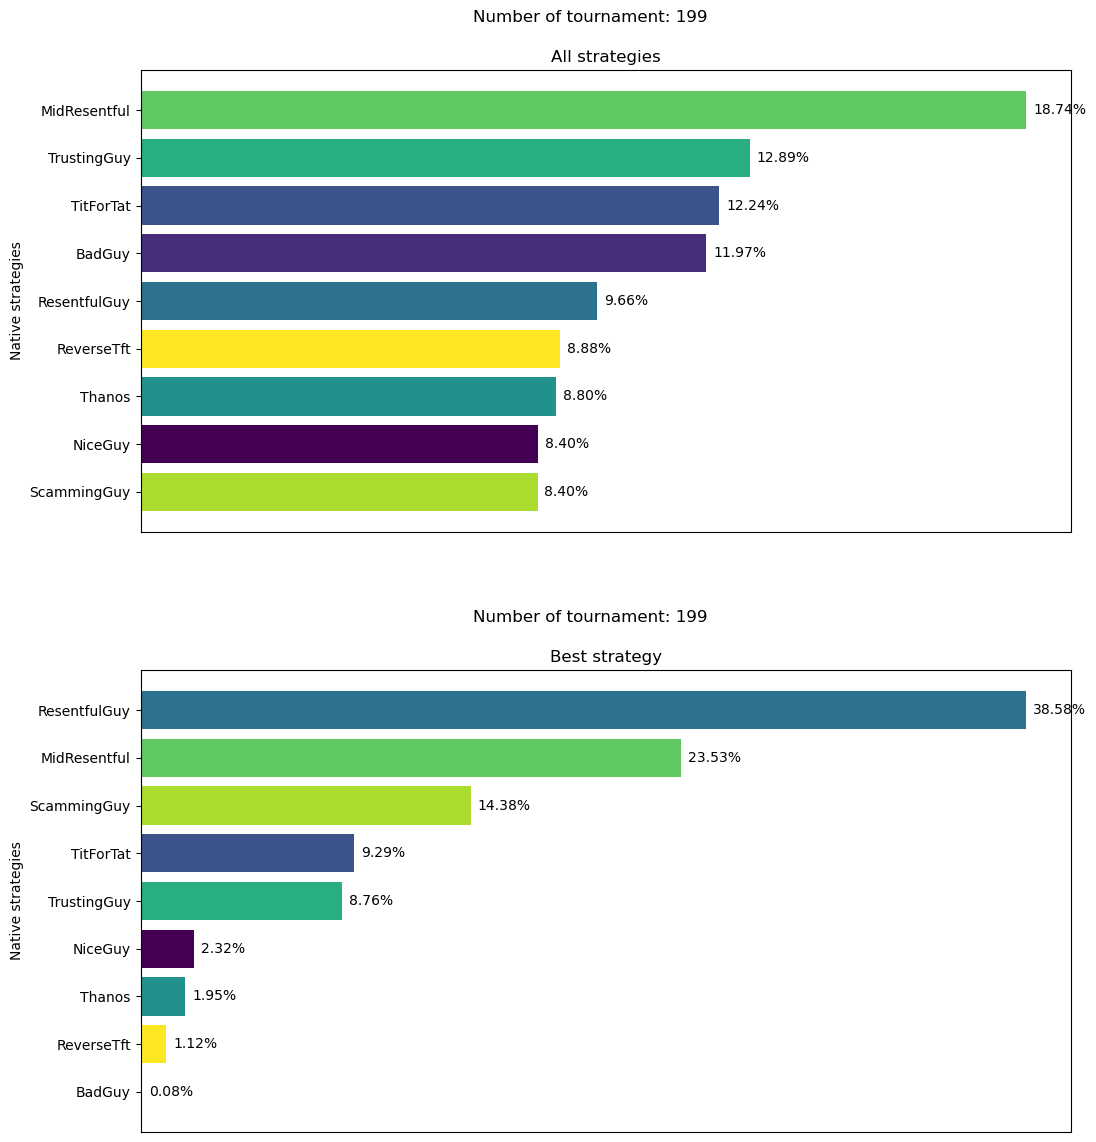

In [89]:
# mutant_list , name_list = get_m_list( "random", [ 'N', 'B', 'U', 'R' ],  N_gen = 30, N_mut = 50 )
# classification, frames = m_tournament( participants = mutant_list , part_names = name_list, N_rounds = 15, iter=200, pressure = 10,  M = Payoff )

make_a_gif( frames, t_key='tournament', p_key = 'Strategies', image_keys = np.array([[ 'p',], [ 'P', ],] ), image_titles = [ ['All strategies',], ['Best strategy',] ] )
# for game in classification :
#     print("\nNew Game\n")
#     for player in game : 
#         print(player)
# print( mutant_list[ classification[-1][0][0] ] )

# print( mutant.from_genome('BEATRICE_BERGAMIN') )


In [90]:
def make_a_gif( data_frame, t_key='tournament', p_key = 'Strategies', image_keys = np.array([[ 'p',], [ 'P', ],] ), image_titles = [ ['All strategies',], ['Best strategy',] ], y_label = f"Native strategies" ) :
    # getting the separated dataframes based of tournament number
    frame = data_frame[ t_key ].unique()

    # getting the number of participants
    n_part = len( data_frame[ p_key ].unique() )
    
    #---------------------------------------COLORS-----------------------------------------------------------------
    
    # chosing a colormap
    colormap = plt.cm.viridis

    # generating color sfumatures, n_part is number of colors used
    colors = [colormap(i) for i in np.linspace(0, 1, n_part)]

    # converting colors into hexadecimanl colors for some reasons
    colors_hex = [matcol.rgb2hex(c) for c in colors]

    # creating a dictionary for color to strategy identification
    color_dic = dict( zip(data_frame[p_key].unique(), colors_hex))
    #---------------------------------------COLORS-----------------------------------------------------------------

    # the number of columns is determined by the number of parameter used
    row_n, col_n = image_keys.shape
    
    # generating the base figure
    fig = plt.figure(constrained_layout=False, figsize=(12*col_n,6*row_n) )
    subfigs = fig.subfigures( nrows=row_n, ncols=1 )
    
    def animate( frame ):
        # getting the exact data
        f = data_frame[data_frame[t_key] == frame]

        # cycling over images
        for i in range( row_n ) :
            # clearing image at previous frame
            subfigs[i].clear()
            axs = subfigs[i].subplots( nrows=1, ncols=col_n )
            if col_n == 1 : axs = [ axs ]
            subfigs[i].suptitle(f"Number of tournament: {frame}")
            for j in range( col_n ) : 
                ax = axs[j]
                key = image_keys[i][j]
                # clearing image at previous frame
                ax.clear()
                if not f.empty:
                    sorted_data = f.nlargest( n_part, key ).sort_values( key, ascending=True ) 
                    barh = ax.barh(sorted_data[p_key],sorted_data[key], color=[color_dic[strategy] for strategy in sorted_data[p_key]] )
                    # setting bar labels
                    ax.bar_label(barh, labels = [ f"{b*100:.1f}%" for b in sorted_data[key] ], padding = 5)
                    # disabling x ticks
                    ax.set_xticks([])
                    # disabling x label
                    ax.set_xticklabels([])
                    # setting y label
                    ax.set( ylabel= y_label)
                    ax.set( title = image_titles[i][j])

                else:
                    print(f"No data for tournament: {frame}")

    # global animation
    anim = animation.FuncAnimation(fig, animate, frames=frame, interval=500, repeat=False)

    # animation saving using Pillow for .gif
    anim.save( 'multiple_animation.gif', writer='pillow')


In [110]:
# st = [ ( 'Thanos', 0.3 ), ( 'TitForTat', 0.7 ), ( 'NiceGuy', 1.) ]
# dic = { i : strategies[st[i][0]] for i in range(len(st)) }
# if ( not ( bad_guy in dic.values() ) ) : dic[ len(dic) ] = bad_guy
# print([ (i, dic[i])  for i in dic ])
# print( sum( np.array( [ 0.1, 0.5, 0.3 ] ) ) )

# import copy
# user = mutant( 'user', [ ( 'NiceGuy', 0.2 ), ( 'TitForTat', 0.5 ), ( 'Thanos', 0.1 ) ] )

# copy method
# unuser = copy.deepcopy( user )
# unuser.mutate()
# unuser.name = 'unuser'

# print( user )
# print( unuser )
# print( [ user.move() for i in range(10) ] )
# print( tit_for_tat( round_number = 0, match_history = [[]], player_index = 0 ) )
# print( list(strategies.keys())[0] )

#test with dictionary
# for i in range(10) : user.mutate()
# strategies[ 'user' ] = user.move

# mutate and move test
# for i in range(10) :
#     user.mutate()
#     print(user, user.move( ))
# for i in range(10) :
#     user.mutate()
#     print(user, user.move( ))

# print(user)
# user.mutate()
# print(user)
# user.mutate()
# print(user)
# user.mutate()
# print(user)
# user.mutate()
# print(user)
# user.mutate()
# print(user)
# user.mutate()
# print(user)

# print(user)
# print(unuser)

# for i in range(100):
#     user.mutate()
#     unuser.mutate()

# print(user)
# print(unuser)

# gen = mutant.from_genome( "NNNBBURSI0" )
# gen.mutate()
# print( gen )
# print( gen.genome( 30 ) )

# A = mutant.from_genome( "B" )
# B = mutant.from_genome( "N" )
# C = mutant.from_genome( "U" )
# A.mutate()
# B.mutate()
# C.mutate()
# print( A, B, C )
# strategies[ A.name ] = A.move
# strategies[ B.name ] = B.move
# strategies[ C.name ] = C.move
# print( m_tourney( player_list=[ A.name, B.name, C.name], N_rounds = 10, M = Payoff ) )
# del strategies[ A.name ]
# del strategies[ B.name ]
# del strategies[ C.name ]

# normal_names = list( mutant.genes.keys() )
# normal_names.remove( 'S' )
# normal_names.remove( 'F' )
# normals = [ mutant.from_genome( g ) for g in normal_names ]
# [print(n) for n in normals ]
# for n in normals :
#     strategies[ n.name ] = n.move
# result = m_tourney( player_list=normal_names, N_rounds = 10, M = Payoff )
# #for item in result: print(item)
# print("\nHere's the Ranking at the end of the tourney:")
# # Sorted gives a copy, while using LIST.sort() does it in place.
# Ranking = sorted(result,reverse=True, key=lambda x: x[1])
# for item in Ranking: print(item)
# for n in normals :
#     del strategies[ n.name ]
# print(list(strategies.keys()))


# print ( match( 'NiceGuy', 'ScammingGuy', N_rounds = 10, M = Payoff ) )
# print ( match( 'BadGuy', 'ScammingGuy', N_rounds = 10, M = Payoff ) )
# print ( match( 'ResentfulGuy', 'ScammingGuy', N_rounds = 10, M = Payoff ) )
# print ( match( 'MainlyNice', 'ScammingGuy', N_rounds = 10, M = Payoff ) )
# print ( match( 'TitForTat', 'ScammingGuy', N_rounds = 10, M = Payoff ) )


# strategies[ gen.name ] = gen.move
# print(  match( gen.name, 'ScammingGuy', N_rounds = 10, M = Payoff ) )
# for i in range( 10 ) : gen.mutate()
# print(  match( gen.name, 'ScammingGuy', N_rounds = 10, M = Payoff ) )
# print( match( 'user', 'BadGuy', 20, M = Payoff ) )
# del strategies[ 'user' ]
# print( [ i for i in strategies ] )

# ('BadGuy1', 106)
# ('ResentfulGuy1', 103)
# ('MidResentful1', 97)
# ('TitForTat1', 91)
# ('Thanos1', 82)
# ('NiceGuy1', 76.0)
# ('ReverseTft1', 76.0)
# r_genomes = np.array( [ np.array( [ 'A', 'N', 'B', 'R' ] ), np.array( [ 'I', 'U', 'T', 'S' ] ) ])
# genomes = [ ''.join(g) for g in r_genomes ]
# for i in genomes : print( i )
# mutant_list , name_list = get_m_list( "physicist" )
mutant_list , name_list = get_m_list( "test" )
classification = m_tournament( participants = mutant_list , part_names = name_list, N_rounds = 10, iter=20, pressure = 2,  M = Payoff )
# print( classification )
# for mut in mutant_list : print(mut)
for game in classification :
    print("\nNew Game\n")
    for player in game : 
        print(player)
print( mutant_list[ classification[-1][0][0] ] )


New Game

('EDOARDO_D_AMORE', 397)
('BROCCO_LUCA', 395)
('PIRAZZO_TOMMASO', 394)
('ZARA_MIRIAM', 390)
('BEATRICE_BERGAMIN', 385.0)
('SCHIAVINATO_ALBERTO', 381)
('CORTE_RICCARDO', 381)
('BORTOLATO_ANGELA', 380)
('POCCIANI_GABRIELE', 379)
('CAFAGNO_SAMUELE', 376)
('CONTE_WILLIAM', 372)
('PIERIPOLLI_LEONARDO', 371)
('BEZZI_FILIPPO', 368)
('GASPAROTTO_GIACOMO', 367)
('JAMILOV_JAVLONBEK', 362)
('LENA_MARGHERITA', 359.0)
('BELLI_LUIGI', 354)
('TAMARIN_CHIARA', 354)
('DI_LUCIA_SOFIA', 344)
('PONCHIO_MATTIA', 337)
('FASIOLO_GIORGIA', 332)
('TUSCANO_ALESSIO', 322)
('SECCO_BENEDETTO', 311)
('CAVALLIN_JONATHAN', 288)
('NAPOLEONE_GIOVANNI', 286)

New Game

('EDOARDO_D_AMORE_0', 433)
('BROCCO_LUCA_0', 414.0)
('ZARA_MIRIAM', 402)
('BEATRICE_BERGAMIN', 388)
('EDOARDO_D_AMORE', 382)
('PIRAZZO_TOMMASO', 381)
('GASPAROTTO_GIACOMO', 381)
('BROCCO_LUCA', 378)
('CAFAGNO_SAMUELE', 371)
('CORTE_RICCARDO', 365)
('FASIOLO_GIORGIA', 360)
('LENA_MARGHERITA', 359.0)
('JAMILOV_JAVLONBEK', 356)
('BELLI_LUIGI', 355